# Logistic Regression Classifer on LDS Imputed Dataset
we use logistic regression (LR) to predict Sepsis from vital signal, lab test, and demographics data.

## Assistant Functions

In [1]:
def predictors_labels_allocator(df):
    
    """
    function that allocate predictors and labels
    
    @param: df: Dataframe, complete dataframe
    @return: X: Numpy Array, predictors
             y: Numpy Array, labels
    """
    col_names = df.columns
    X = np.array(df[col_names[:-2]].values)
    y = df[col_names[-2]].values
    
    return X, y

In [2]:
def F(beta, precision, recall):
    
    """
    Function that calculate f1, f2, and f0.5 scores.
    
    @params: beta, Float, type of f score
             precision: Float, average precision
             recall: Float, average recall
    
    @return: Float, f scores
    """
    
    return (beta*beta + 1)*precision*recall / (beta*beta*precision + recall)

## Load the data
We begin by loading the standard modules.

In [3]:
# import packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import dill    # save or restore notebook session

from sklearn import linear_model, preprocessing
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from plot_metric.functions import BinaryClassification

In [4]:
# create a list of patient file names
train_dir = './data/LDS/train/'
valid_dir = './data/LDS/valid/'
test_dir = './data/LDS/test/'

tr_patients = [p for p in sorted(os.listdir(train_dir))]
vld_patients = [p for p in sorted(os.listdir(valid_dir))]
ts_patients = [p for p in sorted(os.listdir(test_dir))]

print('num training patients:', len(tr_patients))
print('num valid patients:', len(vld_patients))
print('num test patients:', len(ts_patients))

num training patients: 14237
num valid patients: 3050
num test patients: 3050


Concate patients in each category and create separate dataframes: `train_df`, `valid_df`, and `test_df`.

In [6]:
import pickle
# concate patients
# train_df = concat_patients(train_dir, tr_patients)
# valid_df = concat_patients(valid_dir, vld_patients)
# test_df = concat_patients(test_dir, ts_patients)

# # save dataframes to pickle files
# with open('data_baseline.pickle', 'wb') as f:
#     pickle.dump([train_df, valid_df, test_df], f)

# with open('data_baseline.pickle', 'rb') as f:
#     train_df, valid_df, test_df = pickle.load(f)
with open('data_LDS.pickle', 'rb') as f:
    train_df, valid_df, test_df = pickle.load(f)

Check missing data.

In [7]:
# check data missingness.
print('train data has missing values:', train_df.isnull().sum().sum() != 0)
print('valid data has missing values:', valid_df.isnull().sum().sum() != 0)
print('test data has missing values:', test_df.isnull().sum().sum() != 0)

train data has missing values: False
valid data has missing values: False
test data has missing values: False


## Logistic Regression Classification for Sepsis
We first separate features (X) and labels (y) for all datasets. Then we fit the `LogisticRegression` model on training data.

In [8]:
Xtr, ytr = predictors_labels_allocator(train_df)
Xvld, yvld = predictors_labels_allocator(valid_df)
Xts, yts = predictors_labels_allocator(test_df)

Define scaler `StandardScaler`. Fit the scaler on training data. Obtain scaled training, valid, and test data using `transform`.

In [9]:
# define scaler
scaler = preprocessing.StandardScaler()

# fit and transform data
scaler.fit(Xtr)
Xtr = scaler.transform(Xtr)
Xvld = scaler.transform(Xvld)
Xts = scaler.transform(Xts)

Create a `LogisticRegression` object `logreg` and fit the training data.

In [10]:
logreg = linear_model.LogisticRegression(C=10, solver='saga', max_iter=1000)
logreg.fit(Xtr, ytr)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Measure the accuracy of the classifer. That is, use customized score calculator on the predicted labels. The higher the score, the better the model performs. Below, we will properly measure the accuracy on cross-validation data.

In [11]:
yhat = logreg.predict(Xvld)
acc = np.mean(yhat == yvld)
print('Accuracy on the training data is {0:f}'.format(acc))

Accuracy on the training data is 0.977489


## Interpreting the Weight Vector
Create a stem plot of the coefficients, W in the logistic regression model. The most significant features have larger values in the stem plot.

<StemContainer object of 3 artists>

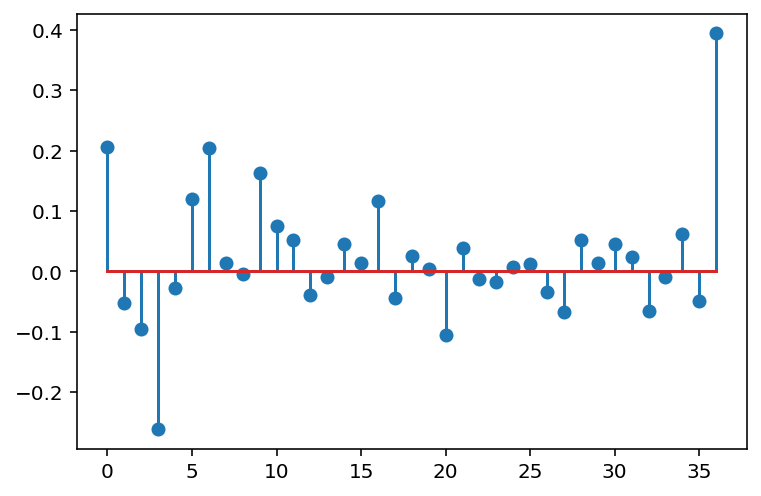

In [12]:
W = logreg.coef_.ravel()
plt.stem(W, use_line_collection=True)

From the stem plot, we see four significant features that are most involved in the prediction of Sepsis.

In [13]:
ind = np.argsort(np.abs(W))
for k in range(1, 5):
    i = ind[-k]
    name = train_df.columns[:-2][i]
    print('The {0:d} most significant feature is {1:s}'.format(k, name))

The 1 most significant feature is ICULOS
The 2 most significant feature is SBP
The 3 most significant feature is HR
The 4 most significant feature is Resp


## Hyperparameter Tuning
Identify hyperparameters for tuning. Create lists of values for these hyperparameters. Use `GridSearchCV` to select the optimal model for test data prediction.

In [11]:
# create a logistic regression model
logreg = linear_model.LogisticRegression(solver='saga', max_iter=1000)

In [12]:
# create hyperparameter search space
# create regularization penalty space
penalty = ['l1', 'l2']

# create regularization hyperparameter space
C = np.logspace(-2, 3, 10)

# create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

Create `GridSearchCV` and fit the best model.

In [13]:
# create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

# best model
best_model = clf.fit(Xtr, ytr)

Show the hyperparameters of the best model.

In [15]:
best_model.best_params_

{'C': 0.01, 'penalty': 'l1'}

## Test data prediction and performance
Predict test data labels using the best model.

In [16]:
# predict labels for test data
yhat_ts = best_model.predict(Xts)
# obtain the accuracy on the result
acc_ts = np.mean(yhat_ts == yts)
print('Accuracy on the test data is {0:f}'.format(acc_ts))

Accuracy on the test data is 0.978882


Plot ROC and PR curve to show model performance.

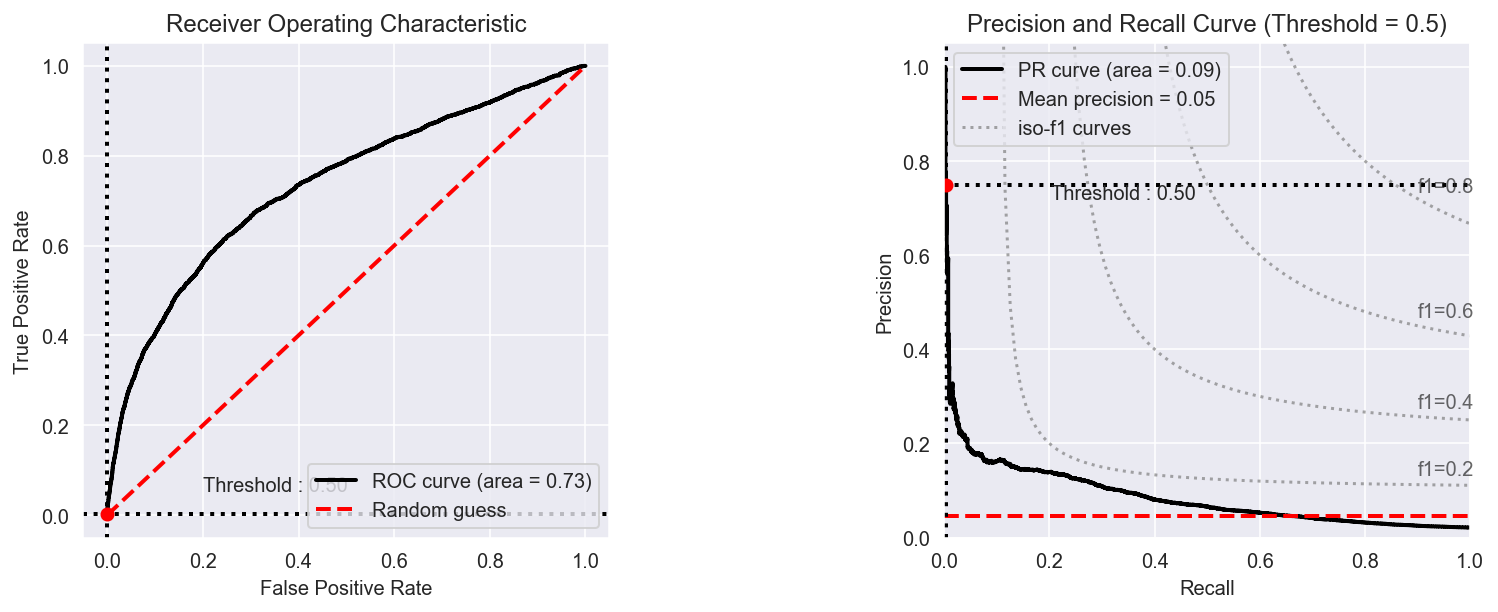

In [17]:
# prediction probability
yhat_probas = best_model.predict_proba(Xts)[:,1]

# visualisation with plot_metric
bc = BinaryClassification(yts, yhat_probas, labels=["nonSepsis", "Sepsis"])

# plots
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,3), colspan=2)
bc.plot_precision_recall_curve()
plt.show()

Classification report.

In [45]:
# precision, recall, and f1 f2 scores
precision, recall, _ = precision_recall_curve(yts, yhat_probas)
fpr, tpr, _ = roc_curve(yts, yhat_probas)

print('f1 score {0:.4f}:'.format(F(1, np.mean(precision), np.mean(recall))))
print('f2 score {0:.4f}:'.format(F(2, np.mean(precision), np.mean(recall))))
print('precision {0:.4f}:'.format(precision_score(yts, yhat_ts)))
print('recall {0:.4f}:'.format(recall_score(yts, yhat_ts)))
print('AUPRC {0:.4f}:'.format(auc(recall, precision)))
print('AUROC {0:.4f}:'.format(auc(fpr, tpr)))
print('Acc {0:.4f}:'.format(accuracy_score(yts, yhat_ts)))

# report
bc.print_report()

f1 score 0.0860:
f2 score 0.1825:
precision 0.7273:
recall 0.0032:
AUPRC 0.0884:
AUROC 0.7328:
Acc 0.9789:
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

   nonSepsis       0.98      1.00      0.99    115737
      Sepsis       0.73      0.00      0.01      2502

    accuracy                           0.98    118239
   macro avg       0.85      0.50      0.50    118239
weighted avg       0.97      0.98      0.97    118239

